In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

from pathlib import Path
import pandas as pd
import numpy as np

import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, DataFrame, Row, Window
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

import statsmodels.api as sm
import scipy.stats as stats

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from synapse.ml.lightgbm import *

pio.renderers.default = "iframe"

In [2]:
def fix_up_df(df: pd.DataFrame):
    log_transform = [
        "n_craters_in_study_region",
        "center_to_center_nearest_neighbor_distance_mean",
        "center_to_center_nearest_neighbor_distance_stdev",
        "center_to_center_nearest_neighbor_distance_min",
        "center_to_center_nearest_neighbor_distance_max",
        "radius_mean",
        "radius_stdev"
    ]

    df = df[df.n_craters_added_in_study_region > 100].reset_index().copy()
    df["z"] = df.z.fillna(0)
    df["za"] = df.za.fillna(0)
    df["log_n_craters_added_in_study_region"] = np.log(df.n_craters_added_in_study_region)
    df["craters_removed"] = df.n_craters_added_in_study_region - df.n_craters_in_study_region
    df["log_craters_removed"] = np.log(1 + df.craters_removed)
    for x in log_transform:
        df[f"log_{x}"] = np.log(1 + df[x])
    return df

# def fix_up_df(df: pd.DataFrame):
#     df["z"] = df.z.fillna(0)
#     df["za"] = df.za.fillna(0)
#     df["percent_rim_to_rim_nearest_neighbors_zero"] = df.n_non_zero_rim_to_rim_nearest_neighbor_distances / df.n_craters_in_study_region
#     df["log_n_craters_added_in_study_region"] = np.log(df.n_craters_added_in_study_region)
#     df["craters_removed"] = df.n_craters_added_in_study_region - df.n_craters_in_study_region
#     df["log_craters_removed"] = np.log(1 + df.craters_removed)
#     for x in ivs:
#         df[f"log_{x}"] = np.log(1 + df[x])
#     return df

In [18]:
# base_path = "/data/saturation/random_runs_20230812"
base_path = "/data/saturation/ir_random_1"

ivs = [
    "slope",
    # "effective_radius_multiplier",
    # "r_stat_multiplier",
    # "min_rim_percentage",
    # "z",
    "za",
    "n_craters_in_study_region",
    # "log_n_craters_in_study_region",
    "areal_density",
    "areal_density_overlap_2",
    "areal_density_overlap_3",
    "center_to_center_nearest_neighbor_distance_mean",
    "center_to_center_nearest_neighbor_distance_stdev",
    "center_to_center_nearest_neighbor_distance_min",
    "center_to_center_nearest_neighbor_distance_max",
    # "log_center_to_center_nearest_neighbor_distance_mean",
    # "log_center_to_center_nearest_neighbor_distance_stdev",
    # "log_center_to_center_nearest_neighbor_distance_max",
    "radius_mean",
    "radius_stdev",
    # "log_radius_mean",
    # "log_radius_stdev",
]

non_constant_ivs = [
    "z",
    "za",
    "areal_density",
    "areal_density_overlap_2",
    "areal_density_overlap_3",
    "center_to_center_nearest_neighbor_distance_mean",
    "center_to_center_nearest_neighbor_distance_stdev",
    "center_to_center_nearest_neighbor_distance_min",
    "center_to_center_nearest_neighbor_distance_max",
    # "log_n_craters_in_study_region",
    "radius_mean",
    "radius_stdev",
    # "log_radius_mean",
    # "log_radius_stdev",
]

In [30]:
sample_size = 50

train_df = pd.read_parquet(f"{base_path}/train_{sample_size}.parquet")
train_df = fix_up_df(train_df)

test_df = pd.read_parquet(f"{base_path}/test_{sample_size}.parquet")
test_df = fix_up_df(test_df)

metric = "information_remaining"

In [5]:
n_cores = 20

spark = SparkSession.builder \
                    .master(f"local[{n_cores}]") \
                    .appName("Saturation") \
                    .config("spark.driver.memory", "24g") \
                    .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.11.2") \
                    .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
                    .getOrCreate()
sc = spark.sparkContext

23/09/17 01:23:22 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.86.20 instead (on interface enp8s0)
23/09/17 01:23:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
https://mmlspark.azureedge.net/maven added as a remote repository with the name: repo-1


:: loading settings :: url = jar:file:/home/mason/code/saturation/venv_311/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/mason/.ivy2/cache
The jars for the packages stored in: /home/mason/.ivy2/jars
com.microsoft.azure#synapseml_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-2a9d55c5-db74-4ce7-8783-7927c3e0607e;1.0
	confs: [default]
	found com.microsoft.azure#synapseml_2.12;0.11.2 in central
	found com.microsoft.azure#synapseml-core_2.12;0.11.2 in central
	found org.scalactic#scalactic_2.12;3.2.14 in central
	found org.scala-lang#scala-reflect;2.12.15 in central
	found io.spray#spray-json_2.12;1.3.5 in central
	found com.jcraft#jsch;0.1.54 in central
	found org.apache.httpcomponents.client5#httpclient5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpcore5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpcore5-h2;5.1.3 in central
	found org.slf4j#slf4j-api;1.7.25 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpmime;4.5.13 in central
	found org.apache.httpc

### LightGBM models

#### Baseline Model

In [31]:
def score_model(model,
                df: pd.DataFrame,
                metric: str,
                assembler: VectorAssembler,
                ivs: List[str],
                features: List[str],
                sample_cadence: int = 1):
    sampled = df.iloc[[x * sample_cadence for x in range(df.shape[0] // sample_cadence)]].copy()
    
    X = poly_transform.transform(sampled[ivs])
    X = pd.DataFrame(X, columns=poly_transform.get_feature_names_out())
    X[metric] = df[metric]
    
    df_spark = spark.createDataFrame(X)
    spark_X = assembler.transform(df_spark)
    pred_df = model.transform(spark_X).toPandas()
    pred_df["simulation_id"] = df["simulation_id"]
    pred_df["slope"] = df["slope"]
    pred_df["n_craters_added_in_study_region"] = df["n_craters_added_in_study_region"]
    pred_df["effective_radius_multiplier"] = df["effective_radius_multiplier"]
    pred_df["min_rim_percentage"] = df["min_rim_percentage"]
    pred_df["r_stat_multiplier"] = df["r_stat_multiplier"]

    rmse = mean_squared_error(pred_df[metric], pred_df["prediction"], squared=False)
    mape = mean_absolute_percentage_error(pred_df[metric], pred_df["prediction"])
    mae = mean_absolute_error(pred_df[metric], pred_df["prediction"])
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}")

    residuals = pred_df[metric] - pred_df["prediction"]
    plt.hist(residuals, bins=50)
    plt.show()

    y_pred_mean_model = [df[metric].mean()] * df.shape[0]
    rmse = mean_squared_error(y_pred_mean_model, df[metric], squared=False)
    mape = mean_absolute_percentage_error(df[metric], y_pred_mean_model)
    mae = mean_absolute_error(y_pred_mean_model, df[metric])
    print(f"Mean model: RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}")
    
    return pred_df


def plot_sim_ci(model,
                df: pd.DataFrame,
                metric: str,
                assembler: VectorAssembler,
                ivs: List[str],
                features: List[str],
                sample_cadence: int = 250):   
    # Show params
    print(f"Simulation parameters: {df[ivs].iloc[0]}")
    
    ns_max = 100000
    plt.plot(df.n_craters_added_in_study_region.iloc[:ns_max],
             df[metric].iloc[:ns_max])
    plt.xlabel("$N_S$")
    plt.ylabel("$A_d$")
    plt.show()

    pred_df = score_model(model, df, metric, assembler, ivs, features, sample_cadence)
   
    fig = go.Figure()
    fig.add_scatter(x=pred_df["n_craters"],
                    y=pred_df["actual"],
                    mode="lines",
                    name="Actual")
    fig.add_scatter(x=pred_df["n_craters"],
                    y=pred_df["prediction"],
                    mode="lines",
                    name="95% Threshold")

    fig.update_layout(
        xaxis_title="$N_S$",
        yaxis_title=metric
    )

    fig.show()

23/09/17 01:35:38 WARN TaskSetManager: Stage 91 contains a task of very large size (4208 KiB). The maximum recommended task size is 1000 KiB.
23/09/17 01:35:38 WARN TaskSetManager: Stage 92 contains a task of very large size (4208 KiB). The maximum recommended task size is 1000 KiB.
23/09/17 01:35:58 WARN TaskSetManager: Stage 93 contains a task of very large size (4208 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.2264, MAE: 0.1978, MAPE: 0.8447


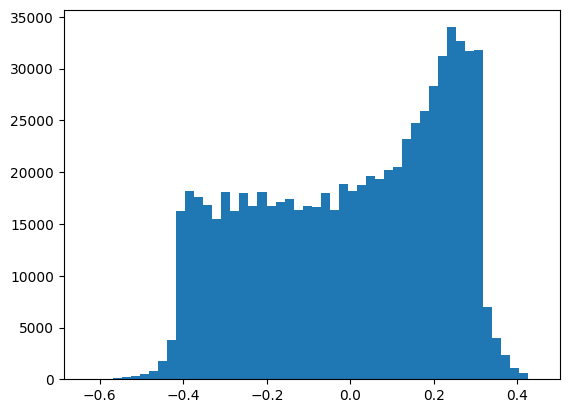

Mean model: RMSE: 0.2817, MAE: 0.2443, MAPE: 0.9935
Training % outside of range: 0.465


23/09/17 01:36:13 WARN TaskSetManager: Stage 94 contains a task of very large size (1087 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.2267, MAE: 0.1982, MAPE: 0.8467


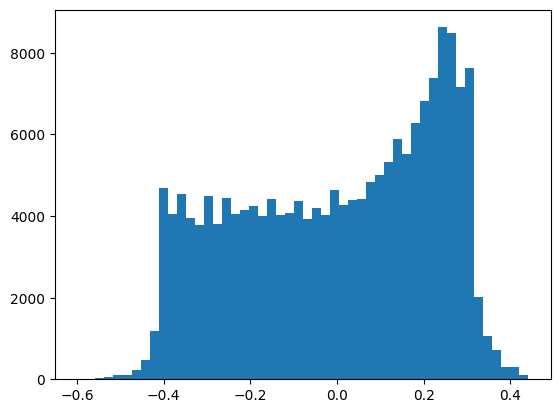

Mean model: RMSE: 0.2809, MAE: 0.2434, MAPE: 0.9924
Testing % outside of range: 0.467
Feature importances:
   areal_density: 14.0
   areal_density_overlap_3: 4.0
   slope: 1.0
   za: 1.0
   n_craters_in_study_region: 0.0
   areal_density_overlap_2: 0.0
   center_to_center_nearest_neighbor_distance_mean: 0.0
   center_to_center_nearest_neighbor_distance_stdev: 0.0
   center_to_center_nearest_neighbor_distance_min: 0.0
   center_to_center_nearest_neighbor_distance_max: 0.0
   radius_mean: 0.0
   radius_stdev: 0.0


In [32]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    # .setObjective('quantile')
     .setObjective('regression')
    .setLabelCol(metric)
    # .setAlpha(0.5)
    .setLearningRate(0.1)
    .setNumIterations(5)
    .setNumLeaves(5)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_5_5 = model

23/09/17 01:36:35 WARN TaskSetManager: Stage 96 contains a task of very large size (4208 KiB). The maximum recommended task size is 1000 KiB.
23/09/17 01:36:36 WARN TaskSetManager: Stage 97 contains a task of very large size (4208 KiB). The maximum recommended task size is 1000 KiB.
23/09/17 01:36:56 WARN TaskSetManager: Stage 98 contains a task of very large size (4208 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.1683, MAE: 0.1414, MAPE: 0.6462


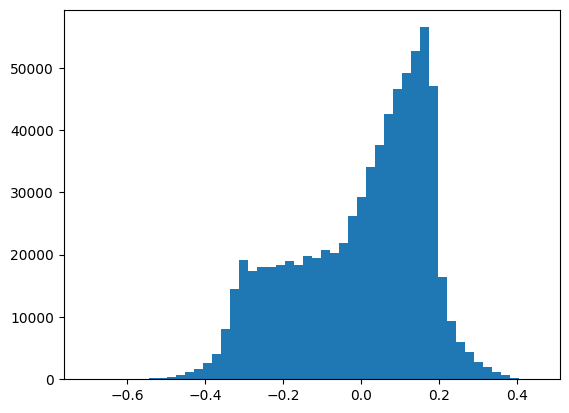

Mean model: RMSE: 0.2817, MAE: 0.2443, MAPE: 0.9935
Training % outside of range: 0.416


23/09/17 01:37:13 WARN TaskSetManager: Stage 99 contains a task of very large size (1087 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.1730, MAE: 0.1457, MAPE: 0.6646


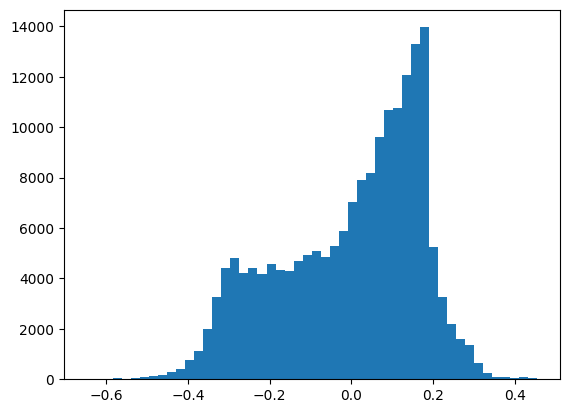

Mean model: RMSE: 0.2809, MAE: 0.2434, MAPE: 0.9924
Testing % outside of range: 0.422
Feature importances:
   areal_density: 111.0
   za: 104.0
   center_to_center_nearest_neighbor_distance_mean: 81.0
   areal_density_overlap_3: 75.0
   slope: 70.0
   center_to_center_nearest_neighbor_distance_max: 16.0
   areal_density_overlap_2: 15.0
   center_to_center_nearest_neighbor_distance_stdev: 9.0
   center_to_center_nearest_neighbor_distance_min: 4.0
   n_craters_in_study_region: 2.0
   radius_stdev: 2.0
   radius_mean: 1.0


In [33]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    # .setObjective('quantile')
     .setObjective('regression')
    .setLabelCol(metric)
    # .setAlpha(0.5)
    .setLearningRate(0.1)
    .setNumIterations(10)
    .setNumLeaves(50)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_10_50 = model

23/09/17 01:37:36 WARN TaskSetManager: Stage 101 contains a task of very large size (4208 KiB). The maximum recommended task size is 1000 KiB.
23/09/17 01:37:36 WARN TaskSetManager: Stage 102 contains a task of very large size (4208 KiB). The maximum recommended task size is 1000 KiB.
23/09/17 01:37:57 WARN TaskSetManager: Stage 103 contains a task of very large size (4208 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.1612, MAE: 0.1345, MAPE: 0.6182


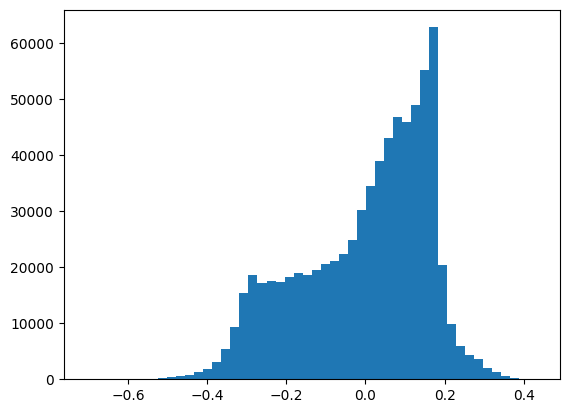

Mean model: RMSE: 0.2817, MAE: 0.2443, MAPE: 0.9935
Training % outside of range: 0.416


23/09/17 01:38:13 WARN TaskSetManager: Stage 104 contains a task of very large size (1087 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.1678, MAE: 0.1404, MAPE: 0.6440


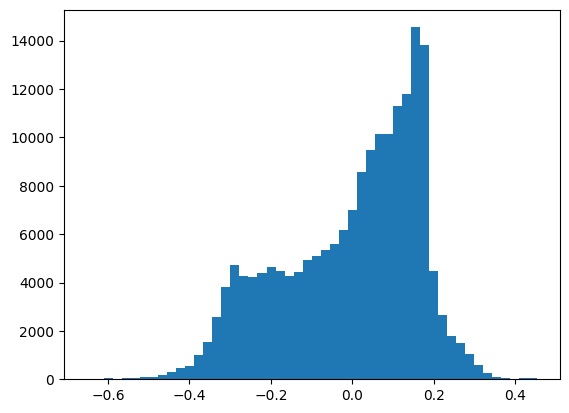

Mean model: RMSE: 0.2809, MAE: 0.2434, MAPE: 0.9924
Testing % outside of range: 0.420
Feature importances:
   za: 197.0
   center_to_center_nearest_neighbor_distance_mean: 192.0
   areal_density: 178.0
   slope: 170.0
   areal_density_overlap_3: 132.0
   areal_density_overlap_2: 36.0
   center_to_center_nearest_neighbor_distance_stdev: 34.0
   center_to_center_nearest_neighbor_distance_max: 20.0
   center_to_center_nearest_neighbor_distance_min: 12.0
   n_craters_in_study_region: 9.0
   radius_stdev: 7.0
   radius_mean: 3.0


In [34]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    # .setObjective('quantile')
     .setObjective('regression')
    .setLabelCol(metric)
    # .setAlpha(0.5)
    .setLearningRate(0.1)
    .setNumIterations(10)
    .setNumLeaves(100)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_10_100 = model

23/09/17 01:38:36 WARN TaskSetManager: Stage 106 contains a task of very large size (4208 KiB). The maximum recommended task size is 1000 KiB.
23/09/17 01:38:36 WARN TaskSetManager: Stage 107 contains a task of very large size (4208 KiB). The maximum recommended task size is 1000 KiB.
23/09/17 01:38:58 WARN TaskSetManager: Stage 108 contains a task of very large size (4208 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.1141, MAE: 0.0839, MAPE: 0.4093


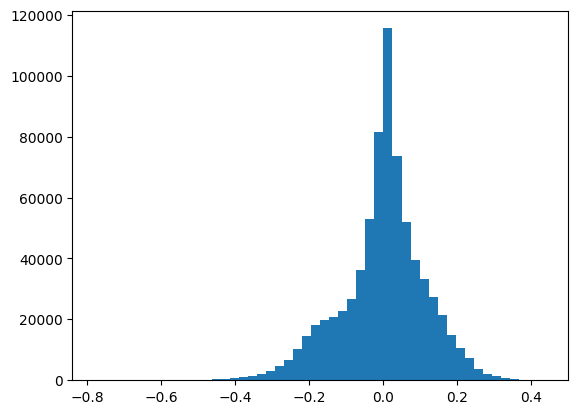

Mean model: RMSE: 0.2817, MAE: 0.2443, MAPE: 0.9935
Training % outside of range: 0.440


23/09/17 01:39:14 WARN TaskSetManager: Stage 109 contains a task of very large size (1087 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.1279, MAE: 0.0935, MAPE: 0.4522


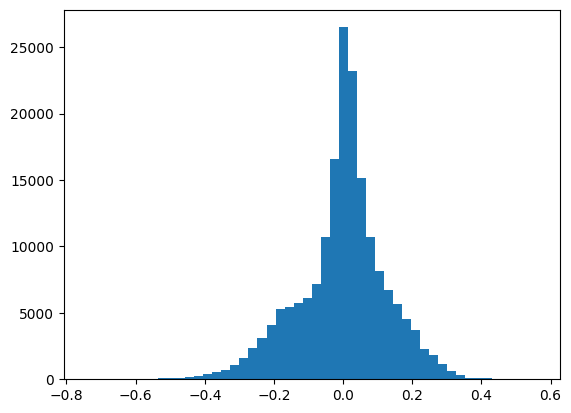

Mean model: RMSE: 0.2809, MAE: 0.2434, MAPE: 0.9924
Testing % outside of range: 0.452
Feature importances:
   center_to_center_nearest_neighbor_distance_mean: 468.0
   za: 443.0
   slope: 393.0
   areal_density: 264.0
   center_to_center_nearest_neighbor_distance_stdev: 251.0
   areal_density_overlap_3: 222.0
   center_to_center_nearest_neighbor_distance_min: 91.0
   radius_mean: 83.0
   areal_density_overlap_2: 74.0
   center_to_center_nearest_neighbor_distance_max: 73.0
   n_craters_in_study_region: 46.0
   radius_stdev: 42.0


In [35]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    # .setObjective('quantile')
     .setObjective('regression')
    .setLabelCol(metric)
    # .setAlpha(0.5)
    .setLearningRate(0.1)
    .setNumIterations(50)
    .setNumLeaves(50)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_50_50 = model

23/09/17 01:39:37 WARN TaskSetManager: Stage 111 contains a task of very large size (4208 KiB). The maximum recommended task size is 1000 KiB.
23/09/17 01:39:37 WARN TaskSetManager: Stage 112 contains a task of very large size (4208 KiB). The maximum recommended task size is 1000 KiB.
23/09/17 01:40:04 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/09/17 01:40:04 WARN TaskSetManager: Stage 113 contains a task of very large size (4208 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.0700, MAE: 0.0488, MAPE: 0.2537


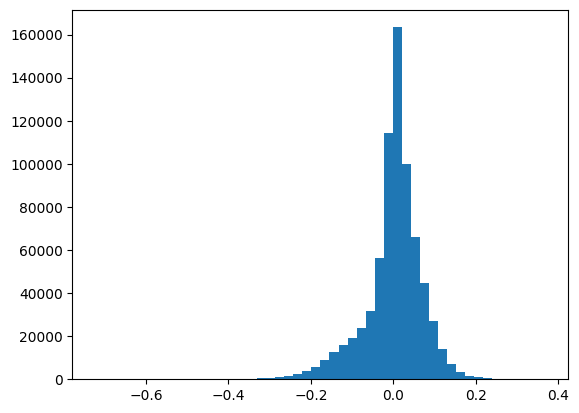

Mean model: RMSE: 0.2817, MAE: 0.2443, MAPE: 0.9935
Training % outside of range: 0.426


23/09/17 01:40:21 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/09/17 01:40:21 WARN TaskSetManager: Stage 114 contains a task of very large size (1087 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.1228, MAE: 0.0863, MAPE: 0.3968


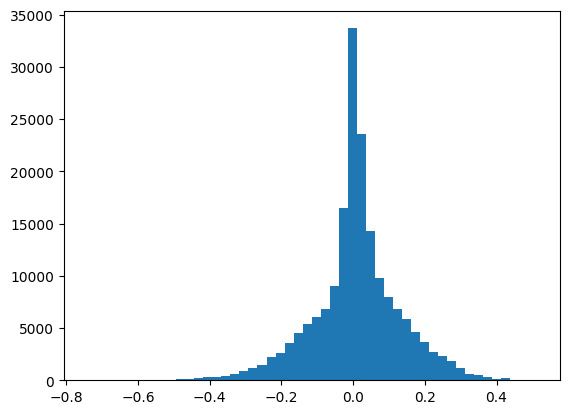

Mean model: RMSE: 0.2809, MAE: 0.2434, MAPE: 0.9924
Testing % outside of range: 0.438
Feature importances:
   slope: 10324.0
   center_to_center_nearest_neighbor_distance_min: 7415.0
   center_to_center_nearest_neighbor_distance_mean: 6451.0
   za: 5308.0
   center_to_center_nearest_neighbor_distance_stdev: 5167.0
   areal_density_overlap_3: 3277.0
   areal_density: 2958.0
   areal_density_overlap_2: 2243.0
   radius_mean: 2074.0
   radius_stdev: 1755.0
   n_craters_in_study_region: 1616.0
   center_to_center_nearest_neighbor_distance_max: 1312.0


In [36]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    # .setObjective('quantile')
     .setObjective('regression')
    .setLabelCol(metric)
    # .setAlpha(0.5)
    .setLearningRate(0.05)
    .setNumIterations(100)
    .setNumLeaves(500)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_100_500 = model

23/09/17 01:40:44 WARN TaskSetManager: Stage 116 contains a task of very large size (4208 KiB). The maximum recommended task size is 1000 KiB.
23/09/17 01:40:44 WARN TaskSetManager: Stage 117 contains a task of very large size (4208 KiB). The maximum recommended task size is 1000 KiB.
23/09/17 01:41:10 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/09/17 01:41:10 WARN TaskSetManager: Stage 118 contains a task of very large size (4208 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.0790, MAE: 0.0576, MAPE: 0.3008


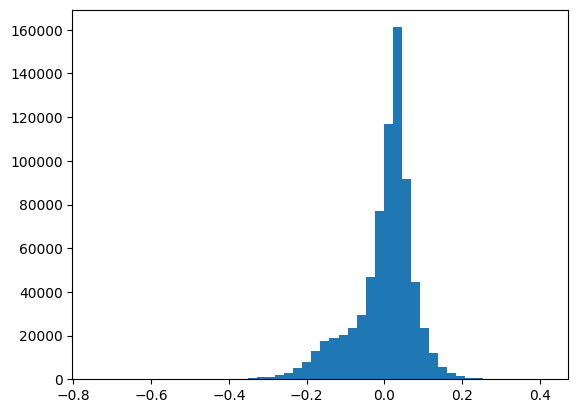

Mean model: RMSE: 0.2817, MAE: 0.2443, MAPE: 0.9935
Training % outside of range: 0.377


23/09/17 01:41:27 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/09/17 01:41:27 WARN TaskSetManager: Stage 119 contains a task of very large size (1087 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.1276, MAE: 0.0935, MAPE: 0.4409


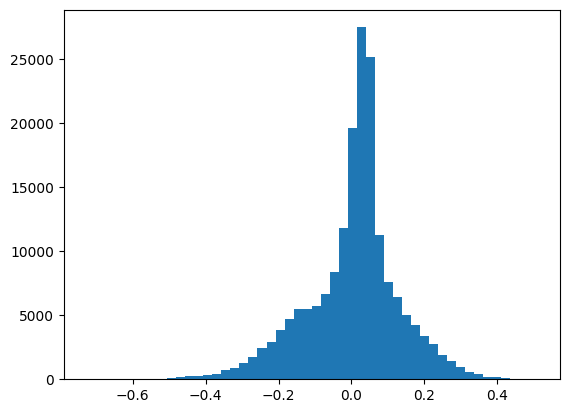

Mean model: RMSE: 0.2809, MAE: 0.2434, MAPE: 0.9924
Testing % outside of range: 0.390
Feature importances:
   slope: 10628.0
   center_to_center_nearest_neighbor_distance_mean: 7226.0
   center_to_center_nearest_neighbor_distance_min: 6760.0
   za: 5984.0
   center_to_center_nearest_neighbor_distance_stdev: 5276.0
   areal_density_overlap_3: 3086.0
   areal_density: 2735.0
   areal_density_overlap_2: 2359.0
   radius_stdev: 1613.0
   radius_mean: 1586.0
   n_craters_in_study_region: 1400.0
   center_to_center_nearest_neighbor_distance_max: 1297.0


In [37]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    # .setObjective('quantile')
     .setObjective('regression')
    .setLabelCol(metric)
    # .setAlpha(0.5)
    .setLearningRate(0.05)
    .setNumIterations(50)
    .setNumLeaves(1000)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_50_1000 = model

23/09/17 01:41:50 WARN TaskSetManager: Stage 121 contains a task of very large size (4208 KiB). The maximum recommended task size is 1000 KiB.
23/09/17 01:41:50 WARN TaskSetManager: Stage 122 contains a task of very large size (4208 KiB). The maximum recommended task size is 1000 KiB.
23/09/17 01:42:37 WARN DAGScheduler: Broadcasting large task binary with size 22.2 MiB
23/09/17 01:42:37 WARN TaskSetManager: Stage 123 contains a task of very large size (4208 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.0362, MAE: 0.0237, MAPE: 0.1234


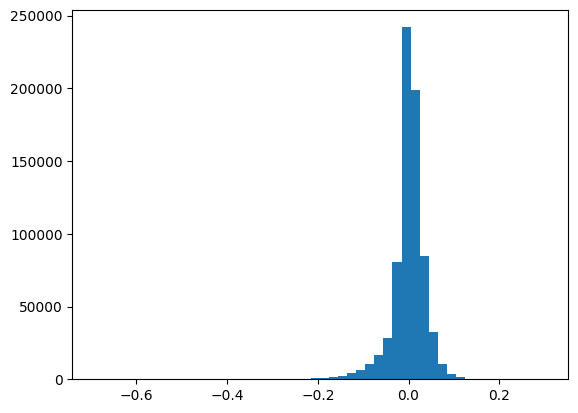

Mean model: RMSE: 0.2817, MAE: 0.2443, MAPE: 0.9935
Training % outside of range: 0.448


23/09/17 01:42:56 WARN DAGScheduler: Broadcasting large task binary with size 22.2 MiB
23/09/17 01:42:56 WARN TaskSetManager: Stage 124 contains a task of very large size (1087 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.1274, MAE: 0.0881, MAPE: 0.3647


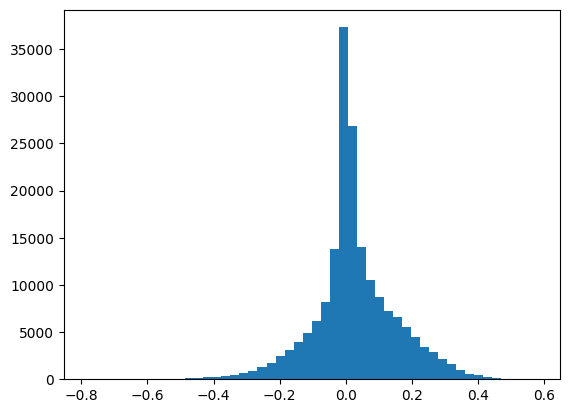

Mean model: RMSE: 0.2809, MAE: 0.2434, MAPE: 0.9924
Testing % outside of range: 0.414
Feature importances:
   center_to_center_nearest_neighbor_distance_min: 48597.0
   slope: 38039.0
   center_to_center_nearest_neighbor_distance_mean: 22821.0
   areal_density: 20442.0
   areal_density_overlap_3: 20278.0
   za: 19862.0
   areal_density_overlap_2: 16845.0
   center_to_center_nearest_neighbor_distance_stdev: 16019.0
   radius_mean: 13495.0
   radius_stdev: 13245.0
   n_craters_in_study_region: 10258.0
   center_to_center_nearest_neighbor_distance_max: 9599.0


In [38]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    # .setObjective('quantile')
     .setObjective('regression')
    .setLabelCol(metric)
    # .setAlpha(0.5)
    .setLearningRate(0.05)
    .setNumIterations(500)
    .setNumLeaves(500)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_500_500 = model

23/09/17 01:43:20 WARN TaskSetManager: Stage 126 contains a task of very large size (4208 KiB). The maximum recommended task size is 1000 KiB.
23/09/17 01:43:20 WARN TaskSetManager: Stage 127 contains a task of very large size (4208 KiB). The maximum recommended task size is 1000 KiB.
23/09/17 01:43:41 WARN TaskSetManager: Stage 128 contains a task of very large size (4208 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.1131, MAE: 0.0767, MAPE: 0.4093


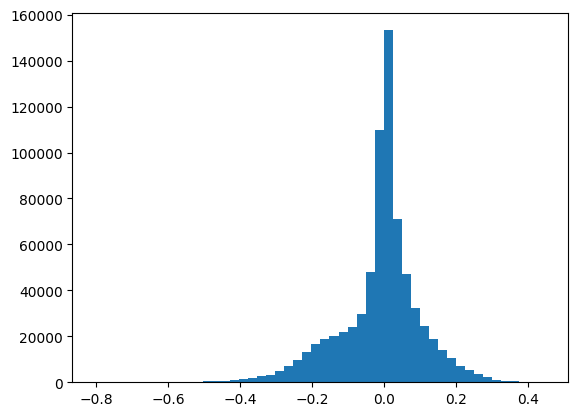

Mean model: RMSE: 0.2817, MAE: 0.2443, MAPE: 0.9935
Training % outside of range: 0.481


23/09/17 01:43:58 WARN TaskSetManager: Stage 129 contains a task of very large size (1087 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.1308, MAE: 0.0912, MAPE: 0.4667


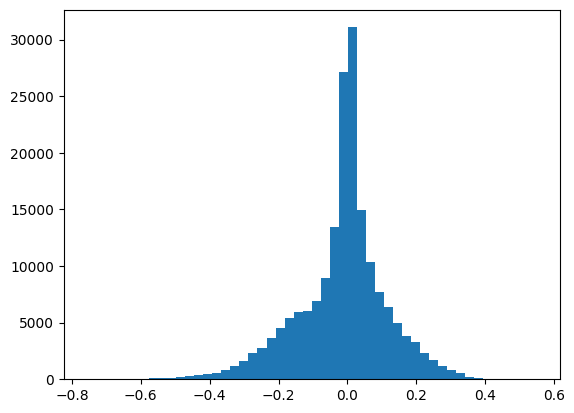

Mean model: RMSE: 0.2809, MAE: 0.2434, MAPE: 0.9924
Testing % outside of range: 0.503
Feature importances:
   za: 1039.0
   center_to_center_nearest_neighbor_distance_mean: 887.0
   slope: 714.0
   areal_density: 476.0
   areal_density_overlap_3: 426.0
   center_to_center_nearest_neighbor_distance_stdev: 334.0
   center_to_center_nearest_neighbor_distance_min: 324.0
   areal_density_overlap_2: 283.0
   center_to_center_nearest_neighbor_distance_max: 182.0
   radius_mean: 130.0
   radius_stdev: 102.0
   n_craters_in_study_region: 53.0


In [39]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    .setObjective('quantile')
     # .setObjective('regression')
    .setLabelCol(metric)
    .setAlpha(0.5)
    .setLearningRate(0.1)
    .setNumIterations(50)
    .setNumLeaves(100)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_50_100_median = model

23/09/17 01:46:00 WARN TaskSetManager: Stage 131 contains a task of very large size (28782 KiB). The maximum recommended task size is 1000 KiB.
23/09/17 01:46:00 WARN TaskSetManager: Stage 132 contains a task of very large size (28782 KiB). The maximum recommended task size is 1000 KiB.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


23/09/17 01:48:06 WARN TaskSetManager: Stage 133 contains a task of very large size (28781 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.0998, MAE: 0.0655, MAPE: 0.3568


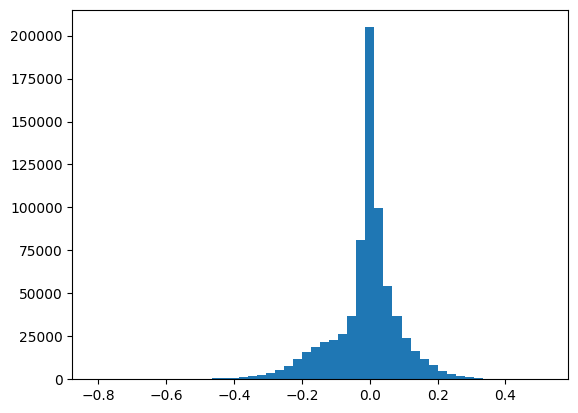

Mean model: RMSE: 0.2817, MAE: 0.2443, MAPE: 0.9935
Training % outside of range: 0.480


23/09/17 01:49:05 WARN TaskSetManager: Stage 134 contains a task of very large size (6584 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.1150, MAE: 0.0785, MAPE: 0.4057


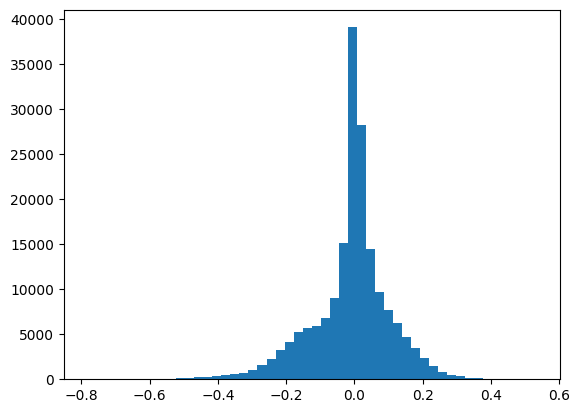

Mean model: RMSE: 0.2809, MAE: 0.2434, MAPE: 0.9924
Testing % outside of range: 0.482
Feature importances:
   za center_to_center_nearest_neighbor_distance_stdev: 495.0
   za center_to_center_nearest_neighbor_distance_mean: 376.0
   slope: 324.0
   n_craters_in_study_region center_to_center_nearest_neighbor_distance_stdev: 285.0
   slope center_to_center_nearest_neighbor_distance_stdev: 276.0
   slope center_to_center_nearest_neighbor_distance_mean: 271.0
   center_to_center_nearest_neighbor_distance_mean: 181.0
   slope areal_density_overlap_2: 158.0
   slope areal_density_overlap_3: 147.0
   za radius_mean: 135.0
   center_to_center_nearest_neighbor_distance_stdev: 127.0
   n_craters_in_study_region areal_density_overlap_2: 121.0
   areal_density: 119.0
   areal_density center_to_center_nearest_neighbor_distance_stdev: 101.0
   za radius_stdev: 86.0
   areal_density center_to_center_nearest_neighbor_distance_mean: 85.0
   slope areal_density: 81.0
   center_to_center_nearest_neighbor

In [40]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    .setObjective('quantile')
     # .setObjective('regression')
    .setLabelCol(metric)
    .setAlpha(0.5)
    .setLearningRate(0.1)
    .setNumIterations(50)
    .setNumLeaves(100)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_50_100_median_degree_2 = model

23/09/17 01:51:11 WARN TaskSetManager: Stage 136 contains a task of very large size (28782 KiB). The maximum recommended task size is 1000 KiB.
23/09/17 01:51:11 WARN TaskSetManager: Stage 137 contains a task of very large size (28782 KiB). The maximum recommended task size is 1000 KiB.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


23/09/17 01:53:24 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/09/17 01:53:24 WARN TaskSetManager: Stage 138 contains a task of very large size (28781 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.0825, MAE: 0.0527, MAPE: 0.3096


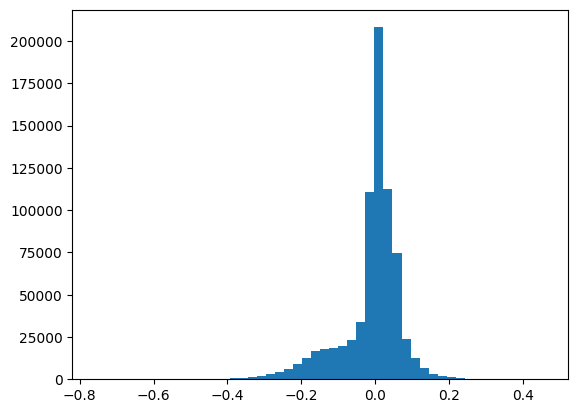

Mean model: RMSE: 0.2817, MAE: 0.2443, MAPE: 0.9935
Training % outside of range: 0.417


23/09/17 01:54:24 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/09/17 01:54:24 WARN TaskSetManager: Stage 139 contains a task of very large size (6584 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.1139, MAE: 0.0816, MAPE: 0.4084


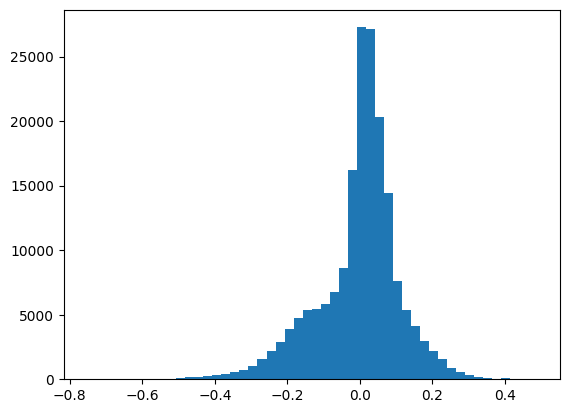

Mean model: RMSE: 0.2809, MAE: 0.2434, MAPE: 0.9924
Testing % outside of range: 0.416
Feature importances:
   slope: 4330.0
   slope center_to_center_nearest_neighbor_distance_mean: 2729.0
   za center_to_center_nearest_neighbor_distance_stdev: 2619.0
   n_craters_in_study_region center_to_center_nearest_neighbor_distance_stdev: 2600.0
   slope center_to_center_nearest_neighbor_distance_stdev: 2219.0
   za center_to_center_nearest_neighbor_distance_mean: 2064.0
   slope center_to_center_nearest_neighbor_distance_min: 1576.0
   center_to_center_nearest_neighbor_distance_min: 1501.0
   center_to_center_nearest_neighbor_distance_stdev: 1180.0
   n_craters_in_study_region center_to_center_nearest_neighbor_distance_min: 1176.0
   center_to_center_nearest_neighbor_distance_mean: 1162.0
   areal_density center_to_center_nearest_neighbor_distance_stdev: 935.0
   areal_density_overlap_3 center_to_center_nearest_neighbor_distance_min: 922.0
   slope areal_density: 918.0
   slope areal_density_ov

In [41]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    .setObjective('quantile')
     # .setObjective('regression')
    .setLabelCol(metric)
    .setAlpha(0.5)
    .setLearningRate(0.05)
    .setNumIterations(50)
    .setNumLeaves(1000)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_50_1000_median_degree_2 = model

In [42]:
# Best: Test ~11.5% RMSE, 8% MAE
# Best including eff radius, min rim perc: ~10% RMSE, 6.5% MAE
# With log-transformed IVs:

### Plot Predictions

In [ ]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    .setObjective('quantile')
     # .setObjective('regression')
    .setLabelCol(metric)
    .setLambdaL2(0.05)
    .setAlpha(0.5)
    .setLearningRate(0.05)
    .setNumIterations(100)
    .setNumLeaves(512)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

In [ ]:
plt.scatter(pred_df[metric], pred_df[metric] - pred_df.prediction, sizes=[1] * pred_df.shape[0])
plt.xlabel("Actual IR")
plt.ylabel("Residual")
plt.show()

In [ ]:
pred_sorted = pred_df.sort_values(metric)
plt.scatter(pred_sorted[metric], (pred_sorted[metric] - pred_sorted.prediction).rolling(1000).std(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("Actual IR")
plt.ylabel("Rolling Stdev of Residuals")
plt.show()

plt.scatter(pred_sorted[metric], (pred_sorted[metric] - pred_sorted.prediction).rolling(1000).mean(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("Actual IR")
plt.ylabel("Rolling Mean of Residuals")
plt.show()

In [ ]:
# Model for IR threshold

threshold = 0.0
xtr = train_df[train_df.information_remaining > threshold].reset_index().copy()
xte = test_df[test_df.information_remaining > threshold].reset_index().copy()

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(xtr[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([xtr[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    .setObjective('quantile')
     # .setObjective('regression')
    .setLabelCol(metric)
    .setLambdaL2(0.05)
    .setAlpha(0.5)
    .setLearningRate(0.05)
    .setNumIterations(50)
    .setNumLeaves(512)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, xtr, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, xte, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

In [ ]:
pred_sorted = pred_df.sort_values(metric)
plt.scatter(pred_sorted[metric], (pred_sorted[metric] - pred_sorted.prediction).rolling(1000).std(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("Actual IR")
plt.ylabel("Rolling Stdev of Residuals")
plt.show()

plt.scatter(pred_sorted[metric], (pred_sorted[metric] - pred_sorted.prediction).abs().rolling(1000).mean(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("Actual IR")
plt.ylabel("Rolling Mean of Abs(Residuals)")
plt.show()

### Plots of 95% CI

In [ ]:
min_data_in_leaf = 500
learning_rate = 0.05
n_iterations = 300
n_leaves = 512
boosting_type = "dart"

threshold = 0.0
xtr = train_df[train_df.information_remaining > threshold].reset_index().copy()
xte = test_df[test_df.information_remaining > threshold].reset_index().copy()

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(xtr[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([xtr[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    .setObjective('quantile')
    .setLabelCol(metric)
    .setBoostingType(boosting_type)
    .setAlpha(0.1)
    .setLearningRate(learning_rate)
    .setNumIterations(n_iterations)
    .setNumLeaves(n_leaves)
    .setMinDataInLeaf(min_data_in_leaf)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

model_10_quantile = model

In [ ]:
model = (LightGBMRegressor()
    .setObjective('quantile')
    .setLabelCol(metric)
    .setBoostingType(boosting_type)
    .setAlpha(0.50)
    .setLearningRate(learning_rate)
    .setNumIterations(n_iterations)
    .setNumLeaves(n_leaves)
    .setMinDataInLeaf(min_data_in_leaf)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

model_50_quantile = model

In [ ]:
model = (LightGBMRegressor()
    .setObjective('quantile')
    .setLabelCol(metric)
    .setBoostingType(boosting_type)
    .setAlpha(0.90)
    .setLearningRate(learning_rate)
    .setNumIterations(n_iterations)
    .setNumLeaves(n_leaves)
    .setMinDataInLeaf(min_data_in_leaf)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

model_90_quantile = model

In [ ]:
pred_df_10_quantile = score_model(model_10_quantile, xte, metric, assembler, ivs, list(X_train.columns))
pred_df_50_quantile = score_model(model_50_quantile, xte, metric, assembler, ivs, list(X_train.columns))
pred_df_90_quantile = score_model(model_90_quantile, xte, metric, assembler, ivs, list(X_train.columns))

pred_df = pred_df_10_quantile.copy()
pred_df["prediction_10_quantile"] = pred_df["prediction"]
pred_df["n_craters_total_10_quantile"] = 1. / pred_df["prediction"] * pred_df["n_craters_in_study_region"]
pred_df["prediction_50_quantile"] = pred_df_50_quantile["prediction"]
pred_df["n_craters_total_50_quantile"] = 1. / pred_df_50_quantile["prediction"] * pred_df["n_craters_in_study_region"]
pred_df["prediction_90_quantile"] = pred_df_90_quantile["prediction"]
pred_df["n_craters_total_90_quantile"] = 1. / pred_df_90_quantile["prediction"] * pred_df["n_craters_in_study_region"]
pred_df["slope"] = test_df["slope"]
pred_df["effective_radius_multiplier"] = test_df["effective_radius_multiplier"]
pred_df["min_rim_percentage"] = test_df["min_rim_percentage"]

In [ ]:
simulation_ids = list(pred_df.simulation_id.unique())

for x in simulation_ids[:5]:
    df = pred_df[pred_df.simulation_id == x].copy()
    print(df.iloc[0][["slope", "effective_radius_multiplier", "min_rim_percentage"]])
    df = df.sort_values("n_craters_added_in_study_region")
    
    fig = plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(111)
    
    plt1 = ax1.plot(df.n_craters_added_in_study_region, df.information_remaining, color='black', label="Information Remaining")
    plt2 = ax1.plot(df.n_craters_added_in_study_region, df["prediction_10_quantile"], color='blue', label="10% Quantile")
    plt3 = ax1.plot(df.n_craters_added_in_study_region, df["prediction_50_quantile"], color='orange', label="50% Quantile")
    plt4 = ax1.plot(df.n_craters_added_in_study_region, df["prediction_90_quantile"], color='green', label="90% Quantile")
    ax1.set_xlabel("N Craters Added")
    ax1.set_ylabel("IR")
    
    lns = plt1 + plt2 + plt3 + plt4
    ax1.legend(lns, [l.get_label() for l in lns], loc=1)
    
    plt.show()

In [ ]:
pred_df["ci_width"] = pred_df["prediction_90_quantile"] - pred_df["prediction_10_quantile"]

pred_sorted = pred_df.sort_values(metric)
plt.scatter(pred_sorted[metric], pred_sorted["ci_width"].rolling(1000).mean(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("IR")
plt.ylabel("Rolling Mean CI Width")
plt.show()

In [ ]:
pred_df["ci_width"] = pred_df["prediction_90_quantile"] - pred_df["prediction_10_quantile"]

pred_sorted = pred_df.sort_values(metric)
plt.scatter(pred_sorted[metric], pred_sorted["ci_width"].rolling(1000).std(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("IR")
plt.ylabel("Rolling Stdev CI Width")
plt.show()

In [ ]:
pred_sorted = pred_df.sort_values("slope")
resid = (pred_sorted["prediction_50_quantile"] - pred_sorted[metric])

plt.scatter(pred_sorted["slope"], resid.rolling(1000).mean(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("Slope")
plt.ylabel("Residual")
plt.show()

In [ ]:
pred_sorted = pred_df.sort_values("effective_radius_multiplier")
resid = (pred_sorted["prediction_50_quantile"] - pred_sorted[metric])

plt.scatter(pred_sorted["effective_radius_multiplier"], resid.rolling(1000).mean(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("Eff Rad Mult")
plt.ylabel("Residual")
plt.show()

In [ ]:
pred_sorted = pred_df.sort_values("min_rim_percentage")
resid = (pred_sorted["prediction_50_quantile"] - pred_sorted[metric])

plt.scatter(pred_sorted["min_rim_percentage"], resid.rolling(1000).mean(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("Min Rim Percentage")
plt.ylabel("Residual")
plt.show()

In [ ]:
simulation_ids = list(pred_df.simulation_id.unique())

for x in simulation_ids[:10]:
    df = pred_df[pred_df.simulation_id == x].copy()
    print(df.iloc[0][["slope", "effective_radius_multiplier", "min_rim_percentage"]])
    df = df.sort_values("n_craters_added_in_study_region")
    
    fig = plt.figure(figsize=(6, 6))
    ax1 = fig.add_subplot(111)
    
    plt1 = ax1.plot(df.n_craters_added_in_study_region, df.n_craters_added_in_study_region, color='black', label="N")
    plt2 = ax1.plot(df.n_craters_added_in_study_region, df["n_craters_total_10_quantile"], color='blue', label="10% Quantile")
    plt3 = ax1.plot(df.n_craters_added_in_study_region, df["n_craters_total_50_quantile"], color='orange', label="50% Quantile")
    plt4 = ax1.plot(df.n_craters_added_in_study_region, df["n_craters_total_90_quantile"], color='green', label="90% Quantile")
    ax1.set_xlabel("N Craters Actual")
    ax1.set_ylabel("N Craters Predicted")
    
    lns = plt1 + plt2 + plt3 + plt4
    ax1.legend(lns, [l.get_label() for l in lns], loc=1)
    
    plt.show()

### Limited AD Models

In [ ]:
min_data_in_leaf = 500
learning_rate = 0.05
n_iterations = 100
n_leaves = 512
boosting_type = "dart"

threshold = 0.0
ad_threshold = 0.30

xtr = train_df[(train_df.information_remaining > threshold) & (train_df.areal_density < ad_threshold)].reset_index().copy()
xte = test_df[(test_df.information_remaining > threshold) & (test_df.areal_density < ad_threshold)].reset_index().copy()

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(xtr[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([xtr[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    .setObjective('quantile')
    .setLabelCol(metric)
    .setBoostingType(boosting_type)
    .setAlpha(0.1)
    .setLearningRate(learning_rate)
    .setNumIterations(n_iterations)
    .setNumLeaves(n_leaves)
    .setMinDataInLeaf(min_data_in_leaf)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

model_10_quantile = model

In [ ]:
model = (LightGBMRegressor()
    .setObjective('quantile')
    .setLabelCol(metric)
    .setBoostingType(boosting_type)
    .setAlpha(0.50)
    .setLearningRate(learning_rate)
    .setNumIterations(n_iterations)
    .setNumLeaves(n_leaves)
    .setMinDataInLeaf(min_data_in_leaf)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

model_50_quantile = model

In [ ]:
model = (LightGBMRegressor()
    .setObjective('quantile')
    .setLabelCol(metric)
    .setBoostingType(boosting_type)
    .setAlpha(0.90)
    .setLearningRate(learning_rate)
    .setNumIterations(n_iterations)
    .setNumLeaves(n_leaves)
    .setMinDataInLeaf(min_data_in_leaf)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

model_90_quantile = model

In [ ]:
pred_df_10_quantile = score_model(model_10_quantile, xte, metric, assembler, ivs, list(X_train.columns))
pred_df_50_quantile = score_model(model_50_quantile, xte, metric, assembler, ivs, list(X_train.columns))
pred_df_90_quantile = score_model(model_90_quantile, xte, metric, assembler, ivs, list(X_train.columns))

pred_df = pred_df_10_quantile.copy()
pred_df["prediction_10_quantile"] = pred_df["prediction"]
pred_df["n_craters_total_10_quantile"] = 1. / pred_df["prediction"] * pred_df["n_craters_in_study_region"]
pred_df["prediction_50_quantile"] = pred_df_50_quantile["prediction"]
pred_df["n_craters_total_50_quantile"] = 1. / pred_df_50_quantile["prediction"] * pred_df["n_craters_in_study_region"]
pred_df["prediction_90_quantile"] = pred_df_90_quantile["prediction"]
pred_df["n_craters_total_90_quantile"] = 1. / pred_df_90_quantile["prediction"] * pred_df["n_craters_in_study_region"]
pred_df["slope"] = test_df["slope"]
pred_df["effective_radius_multiplier"] = test_df["effective_radius_multiplier"]
pred_df["min_rim_percentage"] = test_df["min_rim_percentage"]

In [ ]:
simulation_ids = list(pred_df.simulation_id.unique())

for x in simulation_ids[:5]:
    df = pred_df[pred_df.simulation_id == x].copy()
    print(df.iloc[0][["slope", "effective_radius_multiplier", "min_rim_percentage"]])
    df = df.sort_values("n_craters_added_in_study_region")
    
    fig = plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(111)
    
    plt1 = ax1.plot(df.n_craters_added_in_study_region, df.information_remaining, color='black', label="Information Remaining")
    plt2 = ax1.plot(df.n_craters_added_in_study_region, df["prediction_10_quantile"], color='blue', label="10% Quantile")
    plt3 = ax1.plot(df.n_craters_added_in_study_region, df["prediction_50_quantile"], color='orange', label="50% Quantile")
    plt4 = ax1.plot(df.n_craters_added_in_study_region, df["prediction_90_quantile"], color='green', label="90% Quantile")
    ax1.set_xlabel("N Craters Added")
    ax1.set_ylabel("IR")
    
    lns = plt1 + plt2 + plt3 + plt4
    ax1.legend(lns, [l.get_label() for l in lns], loc=1)
    
    plt.show()

In [ ]:
simulation_ids = list(pred_df.simulation_id.unique())

for x in simulation_ids[:10]:
    df = pred_df[pred_df.simulation_id == x].copy()
    print(df.iloc[0][["slope", "effective_radius_multiplier", "min_rim_percentage"]])
    df = df.sort_values("n_craters_added_in_study_region")
    
    fig = plt.figure(figsize=(6, 6))
    ax1 = fig.add_subplot(111)
    
    plt1 = ax1.plot(df.n_craters_added_in_study_region, df.n_craters_added_in_study_region, color='black', label="N")
    plt2 = ax1.plot(df.n_craters_added_in_study_region, df["n_craters_total_10_quantile"], color='blue', label="10% Quantile")
    plt3 = ax1.plot(df.n_craters_added_in_study_region, df["n_craters_total_50_quantile"], color='orange', label="50% Quantile")
    plt4 = ax1.plot(df.n_craters_added_in_study_region, df["n_craters_total_90_quantile"], color='green', label="90% Quantile")
    ax1.set_xlabel("N Craters Actual")
    ax1.set_ylabel("N Craters Predicted")
    
    lns = plt1 + plt2 + plt3 + plt4
    ax1.legend(lns, [l.get_label() for l in lns], loc=1)
    
    plt.show()

In [ ]:
pred_df["ci_width"] = pred_df["prediction_90_quantile"] - pred_df["prediction_10_quantile"]

pred_sorted = pred_df.sort_values(metric)
plt.scatter(pred_sorted[metric], pred_sorted["ci_width"].rolling(1000).mean(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("IR")
plt.ylabel("Rolling Mean CI Width")
plt.show()

In [ ]:
pred_df["ci_width"] = pred_df["prediction_90_quantile"] - pred_df["prediction_10_quantile"]

pred_sorted = pred_df.sort_values(metric)
plt.scatter(pred_sorted[metric], pred_sorted["ci_width"].rolling(1000).std(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("IR")
plt.ylabel("Rolling Stdev CI Width")
plt.show()

In [ ]:
pred_sorted = pred_df.sort_values("effective_radius_multiplier")
resid = (pred_sorted["prediction_50_quantile"] - pred_sorted[metric])

plt.scatter(pred_sorted["effective_radius_multiplier"], resid.rolling(1000).mean(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("Eff Rad Mult")
plt.ylabel("Residual")
plt.show()

In [ ]:
pred_sorted = pred_df.sort_values("min_rim_percentage")
resid = (pred_sorted["prediction_50_quantile"] - pred_sorted[metric])

plt.scatter(pred_sorted["min_rim_percentage"], resid.rolling(1000).mean(), sizes=[1] * pred_sorted.shape[0])
plt.xlabel("Min Rim Percentage")
plt.ylabel("Residual")
plt.show()